In [1]:
import gym
from utils import *

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Net(nn.Module):
    def __init__(self, act_n, shape, hidden = 512):
        super(Net, self).__init__()
        cnn_out_channel = 64
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, cnn_out_channel, 4, 2, 1),
            nn.ReLU()
        )
        
        w = self.get_conv_out_size(shape[1])
        h = self.get_conv_out_size(shape[2])
        self.cnn_out = w*h*cnn_out_channel
        
        self.actor = nn.Sequential(
            nn.Linear(self.cnn_out, hidden),
            nn.ReLU(),
            nn.Linear(hidden, int(hidden/2)),
            nn.ReLU(),
            nn.Linear(int(hidden/2), act_n),
            nn.Tanh()
        )
        
        self.critic = nn.Sequential(
            nn.Linear(self.cnn_out, hidden),
            nn.ReLU(),
        )
        self.critic_out = nn.Sequential(
            nn.Linear(hidden + act_n, int(hidden/2)),
            nn.ReLU(),
            nn.Linear(int(hidden/2), 1)
        )
    
    def to(self, device):
        self.device = device
        return super(Net,self).to(device)
        
    def convert_input(self, x):
        return x[165:330,200:400].transpose(2,0,1)
        
    def convert_to_action(self, act_v):
        return act_v.argmax()
        
    def get_conv_out_size(self, value):
        return int(int(int(value/2)/2)/2)
    
    def forward(self, x, act_v=None):
        x = torch.FloatTensor(x).to(self.device)
        cnn_out = self.cnn(x).view(-1,self.cnn_out)
        if act_v is None:
            return self.actor(cnn_out)
        else:
            return self.critic_out(torch.cat([self.critic(cnn_out), act_v]))

In [9]:
env = gym.make("CartPole-v0")
act_n = env.action_space.n
obs_n = env.observation_space.shape[0]

env.reset()
r = (env.render("rgb_array")[165:330,200:400].transpose(2,0,1))
env.close()

In [10]:
import matplotlib.pyplot as plt

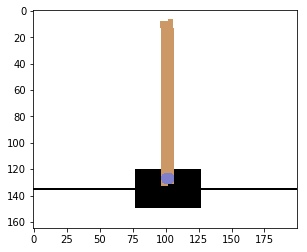

In [11]:
plt.imshow(r.transpose(1,2,0))

In [12]:
LR = 0.001

device = "cuda" if torch.cuda.is_available() else "cpu"

net= Net(act_n, r.shape).to(device)
net_tgt = targetNet(net)
opt = optim.Adam(net.parameters(), LR)

In [ ]:
GAMMA = 0.99

noise = NoiseMaker(act_n, "normal", decay = True)
agent = Agent(env, net, noise, 500)
agent.prepare(2, GAMMA, True)

ST_SIZE = 10000
ST_INIT = 5
ST_DECAY = 1000
ST_BATCH = 32
storage = Replay(ST_INIT, ST_SIZE, True)

In [ ]:
import time
EPOCH = 2
for epoch in range(EPOCH):
    for step in agent.episode(epoch):
        storage.push(step)
        if not storage.is_ready():
            continue
        
        sample, indices, weights = storage.sample(ST_BATCH)
        weights_ = torch.FloatTensor(weights).to(device)
        obs, act_v, noise_v, act, next_obs, rew, done, etc, unroll_n = list(zip(*sample))
        
        obs_ = torch.FloatTensor(obs).to(device)
        act_v_ = torch.FloatTensor(act_v).to(device)
        noise_v_ = torch.FloatTensor(noise_v).to(device)
        act_ = torch.LongTensor(act).unsqueeze(1).to(device)
        next_obs_ = torch.FloatTensor(next_obs).to(device)
        rew_ = torch.FloatTensor(rew).unsqueeze(1).to(device)
        done_ = torch.BoolTensor(done).to(device)
        unroll_n_ = torch.FloatTensor(unroll_n).unsqueeze(1).to(device)

        #critic
        opt.zero_grad()
        q_pred = net(obs_, noise_v_)
        
        q_next = targetNet(next_obs_, targetNet(next_obs_))
        q_next[done] = 0.
        q_target = rew_ + (GAMMA ** unroll_n_) * q_next.detach()
        
        q_loss = weight_ * (q_next - q_target) ** 2
        q_loss.mean().backward()
        opt.step()
        
        storage.update_priorities(indices, q_loss.detach().cpu().numpy())
        
        #actor
        st_decay = torch.exp_(-torch.FloatTensor(len(storage)-indices)/ST_DECAY).unsqueeze(1).to(device)
        act_avg = net(obs_).detach() * (1-st_decay) + act_v_ * st_decay
        q_v = -net(obs_, act_avg)

        actor_loss = q_v.mean()
        actor_loss.backward()
        actor_optim.step()
        
        #target_update
        targetNet.alpha_update()